Example problems: ['branin', 'cantilevered_beam', 'g2', 'g24', 'g6']
Example psizes for first problem: [6, 12, 18]


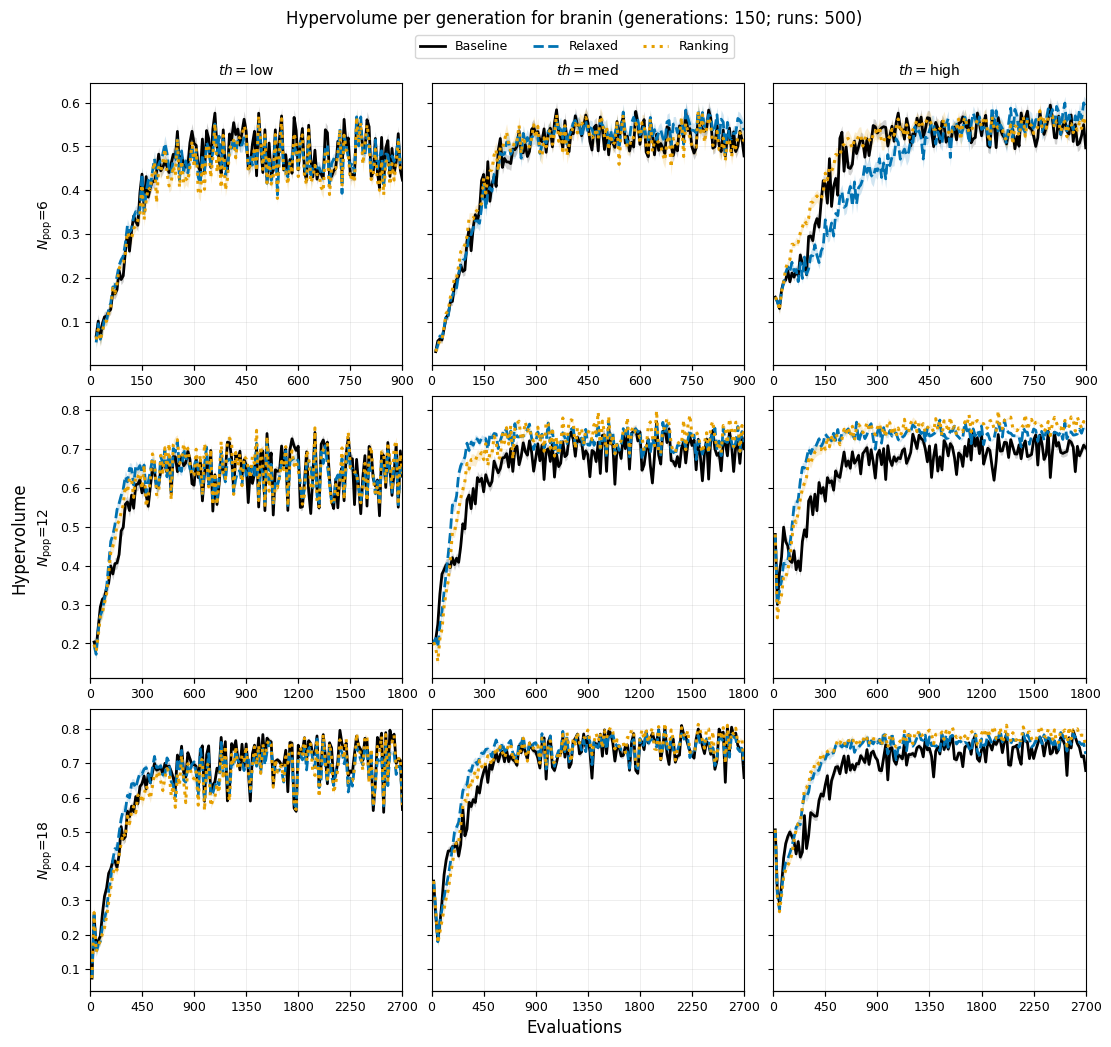

In [52]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator, FixedLocator
import numpy as np
import polars as pl

# Config
DATA_DIR = Path("./results/summary")
OUT_DIR = Path("./figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)

METRICS = {
    "Best-so-far": {
        "mean": "run_best_so_far_mean",
        "lower": "best_ci_lower",
        "upper": "best_ci_upper",
        "ytitle": "Best-so-far feasible objective",
        "title": "Best-so-far (feasible) objective per generation",
        "slug": "best_so_far",
    },
    "Hypervolume": {
        "mean": "hv_mean",
        "lower": "hv_ci_lower",
        "upper": "hv_ci_upper",
        "ytitle": "Hypervolume",
        "title": "Hypervolume per generation",
        "slug": "hv",
    },
}

# filename pattern
PATTERN = re.compile(
    r"^(?P<problem>.+?)_"
    r"(?P<mode>baseline|relaxed|ranking)_"
    r"gen(?P<gen>\d+)_"
    r"runs(?P<runs>\d+)_"
    r"ct(?P<ctlevel>low|med|high)_"
    r"psize(?P<psize>\d+)_summary\.parquet$"
)

CT_ORDER = ["low", "med", "high"]
MODE_ORDER = ["baseline", "relaxed", "ranking"]

# Okabe–Ito palette
OKABE_ITO = {
    "black": "#000000",
    "blue": "#0072B2",
    "orange": "#E69F00",
}

MODE_STYLE = {
    "baseline": {"color": OKABE_ITO["black"], "linestyle": "-", "linewidth": 2.0, "zorder": 3},
    "relaxed": {"color": OKABE_ITO["blue"], "linestyle": "--", "linewidth": 2.0, "zorder": 3},
    "ranking": {"color": OKABE_ITO["orange"], "linestyle": ":", "linewidth": 2.2, "zorder": 3},
}

MODE_LABEL = {
    "baseline": "Baseline",
    "relaxed": "Relaxed",
    "ranking": "Ranking",
}


# Index summary files
def index_summary_files(data_dir: Path) -> pl.DataFrame:
    rows = []
    for p in sorted(Path(data_dir).glob("*_summary.parquet")):
        name = Path(p).name
        m = PATTERN.match(name)
        if not m:
            continue
        d = m.groupdict()
        rows.append(
            {
                "problem": d["problem"],
                "mode": d["mode"],
                "gen": int(d["gen"]),
                "runs": int(d["runs"]),
                "ctlevel": d["ctlevel"],
                "psize": int(d["psize"]),
                "file": str(data_dir / name),
            }
        )
    if not rows:
        raise ValueError(f"No summary files matched pattern in {data_dir}")
    return pl.DataFrame(rows)


idx = index_summary_files(DATA_DIR)


# Helpers
def _read_series(file_path: str, metric_spec: dict) -> pl.DataFrame:
    """Read parquet and return df with evaluations, mean, lower, upper."""
    df = (
        pl.read_parquet(file_path)
        .select(
            [
                "generation",
                metric_spec["mean"],
                metric_spec["lower"],
                metric_spec["upper"],
            ]
        )
        .sort("generation")
    )
    return df


def _plot_one(ax, df: pl.DataFrame, mode: str, metric_spec: dict, ci_alpha: float = 0.18):
    x = df["generation"].to_numpy()
    y = df[metric_spec["mean"]].to_numpy()
    lo = df[metric_spec["lower"]].to_numpy()
    up = df[metric_spec["upper"]].to_numpy()

    style = MODE_STYLE[mode]
    ax.plot(x, y, label=MODE_LABEL[mode], **style)
    ax.fill_between(x, lo, up, color=style["color"], alpha=ci_alpha, linewidth=0)


def plot_problem_psize_metric(
    idx: pl.DataFrame,
    problem: str,
    psize: int,
    metric_key: str,
    *,
    save_pdf: bool = False,
    out_dir: Path = OUT_DIR,
    show: bool = True,
):
    metric_spec = METRICS[metric_key]

    sub = idx.filter((pl.col("problem") == problem) & (pl.col("psize") == psize))
    if sub.is_empty():
        raise ValueError(f"No rows for problem={problem}, psize={psize}")

    gen = int(sub.select(pl.col("gen").unique()).to_series()[0])
    runs = int(sub.select(pl.col("runs").unique()).to_series()[0])

    plt.rcParams.update(
        {
            "font.size": 10,
            "axes.titlesize": 10,
            "axes.labelsize": 10,
            "legend.fontsize": 9,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
            "pdf.fonttype": 42,
            "ps.fonttype": 42,
        }
    )

    fig, axes = plt.subplots(
        1,
        3,
        figsize=(11.0, 3.6),
        sharex=True,
        sharey=True,
        constrained_layout=True,
    )

    missing = []

    for j, ct in enumerate(CT_ORDER):
        ax = axes[j]
        ax.set_title(f"$th = \\mathrm{'ct'}")
        ax.grid(True, which="major", alpha=0.25, linewidth=0.6)

        for mode in MODE_ORDER:
            row = sub.filter((pl.col("ctlevel") == ct) & (pl.col("mode") == mode))
            if row.is_empty():
                missing.append((problem, psize, ct, mode))
                continue
            file_path = row.select("file").to_series()[0]
            df = _read_series(file_path, metric_spec, psize)
            _plot_one(ax, df, mode, metric_spec)

        ax.set_xlabel("Evaluations")

    # shared y label
    axes[0].set_ylabel(metric_spec["ytitle"])

    # global title
    fig.suptitle(
        f"{metric_spec['title']} for {problem} (population size: {psize};  genenerations: {gen}; runs: {runs})", y=1.10
    )

    # single legend (deduplicated)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.18))

    if missing:
        print("Missing series (problem, psize, ctlevel, mode):")
        for m in missing:
            print("  ", m)

    if save_pdf:
        slug = metric_spec["slug"]
        out_path = out_dir / f"fig_{problem}_psize{psize}_{slug}.pdf"
        fig.savefig(out_path, bbox_inches="tight")
        print(f"Saved: {out_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig


def plot_problem_metric_psize_grid(
    idx: pl.DataFrame,
    problem: str,
    metric_key: str,
    psizes: list[int],
    *,
    save_pdf: bool = False,
    out_dir: Path = OUT_DIR,
    show: bool = True,
):
    metric_spec = METRICS[metric_key]
    sub_all = idx.filter(pl.col("problem") == problem)
    if sub_all.is_empty():
        raise ValueError(f"No rows for problem={problem}")

    gen = int(sub_all.select(pl.col("gen").unique()).to_series()[0])
    runs = int(sub_all.select(pl.col("runs").unique()).to_series()[0])

    # Choose consistent generation tick positions for the whole figure
    gen_ticks = np.linspace(0, gen, 7)  # 0..gen with 7 ticks
    gen_ticks = np.round(gen_ticks).astype(int)
    gen_ticks = np.unique(gen_ticks)

    nrows, ncols = len(psizes), len(CT_ORDER)

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(11.0, 3.2 * nrows),
        sharex=True,  # share generation-axis geometry
        sharey="row",  # share y within each row
        constrained_layout=True,
    )
    if nrows == 1:
        axes = axes.reshape(1, -1)

    for ax in axes.flat:
        ax.tick_params(axis="x", which="both", labelbottom=True)

    missing = []

    for i, psize in enumerate(psizes):
        sub_ps = sub_all.filter(pl.col("psize") == psize)
        if sub_ps.is_empty():
            missing.append((problem, psize, "ALL", "ALL"))
            continue

        # row-specific: generation-axis, but tick labels show evaluations
        for j, ct in enumerate(CT_ORDER):
            ax = axes[i, j]

            if i == 0:
                ax.set_title(f"$th = \\mathrm{{{ct}}}$")

            ax.grid(True, which="major", alpha=0.25, linewidth=0.6)

            for mode in MODE_ORDER:
                row = sub_ps.filter((pl.col("ctlevel") == ct) & (pl.col("mode") == mode))
                if row.is_empty():
                    missing.append((problem, psize, ct, mode))
                    continue
                file_path = row.select("file").to_series()[0]
                df = _read_series(file_path, metric_spec)  # NOTE: generation-based now
                _plot_one(ax, df, mode, metric_spec)

            # Primary x-axis: generations (shared for alignment), but hide labels
            ax.set_xlim(0, gen)
            ax.xaxis.set_major_locator(FixedLocator(gen_ticks))
            ax.tick_params(axis="x", which="both", labelbottom=False)

            # Secondary x-axis (evaluations): fixed tick positions mapped from generation ticks
            secax = ax.secondary_xaxis(
                "bottom",
                functions=(lambda g, p=psize: g * p, lambda e, p=psize: e / p),
            )

            eval_ticks = gen_ticks * psize
            secax.xaxis.set_major_locator(FixedLocator(eval_ticks))
            secax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
            secax.tick_params(axis="x", which="both", labelbottom=True)

            if j == 0:
                ax.set_ylabel(f"$N_\\mathrm{{pop}}$={psize}")

    # Force a draw so positions are known
    fig.canvas.draw()

    # Compute center of the subplot grid in figure coordinates
    left = axes[0, 0].get_position().x0
    right = axes[0, -1].get_position().x1
    x_center = (left + right) / 2

    fig.suptitle(
        f"{metric_spec['title']} for {problem} (generations: {gen}; runs: {runs})",
        x=x_center,
        ha="center",
        y=1.05,
    )

    # x-label
    fig.text(x_center, -0.02, "Evaluations", ha="center", va="bottom", fontsize=plt.rcParams["figure.titlesize"])
    fig.supylabel(metric_spec["ytitle"])

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=3,
        frameon=True,
        bbox_to_anchor=(x_center, 1.03),
        bbox_transform=fig.transFigure,
    )

    if missing:
        print("Missing series (problem, psize, ctlevel, mode):")
        for m in missing:
            print("  ", m)

    if save_pdf:
        slug = metric_spec["slug"]
        ps_tag = "-".join(str(p) for p in psizes)
        out_path = out_dir / f"fig_{problem}_psizes{ps_tag}_{slug}.pdf"
        fig.savefig(out_path, bbox_inches="tight")
        print(f"Saved: {out_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig


# Example: plot one figure inline
# Pick a problem and psize that exist in idx:
problems = idx.select("problem").unique().sort("problem").to_series().to_list()
psizes = idx.filter(pl.col("problem") == problems[0]).select("psize").unique().sort("psize").to_series().to_list()
print("Example problems:", problems[:5])
print("Example psizes for first problem:", psizes)

# Plot one:
plot_problem_metric_psize_grid(idx, problem="branin", metric_key="Hypervolume", psizes=[6, 12, 18], show=True)


# Batch: generate and show or save (turn show off for batch)
def batch_generate(
    idx: pl.DataFrame,
    *,
    metrics=None,
    save_pdf: bool = True,
    show: bool = False,
):
    if metrics is None:
        metrics = list(METRICS.keys())

    problems = idx.select("problem").unique().sort("problem").to_series().to_list()
    for problem in problems:
        psizes = idx.filter(pl.col("problem") == problem).select("psize").unique().sort("psize").to_series().to_list()
        for psize in psizes:
            for metric_key in metrics:
                plot_problem_psize_metric(
                    idx,
                    problem=problem,
                    psize=psize,
                    metric_key=metric_key,
                    save_pdf=save_pdf,
                    out_dir=OUT_DIR,
                    show=show,
                )


def _chunked(lst, k):
    for i in range(0, len(lst), k):
        yield lst[i : i + k]


def batch_generate_grid(
    idx: pl.DataFrame,
    *,
    metrics=None,
    psizes_per_page: int = 3,
    save_pdf: bool = True,
    show: bool = False,
):
    if metrics is None:
        metrics = list(METRICS.keys())

    problems = idx.select("problem").unique().sort("problem").to_series().to_list()

    for problem in problems:
        psizes = idx.filter(pl.col("problem") == problem).select("psize").unique().sort("psize").to_series().to_list()

        for metric_key in metrics:
            for ps_group in _chunked(psizes, psizes_per_page):
                # if last group has <3 psizes, you can either plot anyway or skip
                plot_problem_metric_psize_grid(
                    idx,
                    problem=problem,
                    metric_key=metric_key,
                    psizes=ps_group,
                    save_pdf=save_pdf,
                    out_dir=OUT_DIR,
                    show=show,
                )


# batch-generate PDFs:/
# batch_generate(idx, save_pdf=True, show=False)
